In [147]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from neqr import neqr
from ladder import ladder_up
from enhanced_grover import filter_oracle
from qsubtract import subtract
from qadd import qft_adder
from PIL import Image
import numpy as np



In [148]:
num_bits = 3
intensity_bits =  2

In [149]:
image = np.array([
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,1,1,1,1,0,0],
    [0,0,1,1,1,1,0,0],
    [0,0,1,1,1,1,0,0],
    [0,0,1,1,1,1,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0]

])

In [150]:
def load_image(filepath, size=(16, 16)):
    img = Image.open(filepath).convert('L')  # Grayscale
    img = img.resize(size, Image.Resampling.LANCZOS)
    img_array = np.array(img)
    return img_array

def normalize_image(image, bits=3):
    max_val = 2**bits - 1
    return np.round((image / 255) * max_val).astype(int)

#image = load_image('batman16.jpg',size=(16,16))
#image = normalize_image(image, bits=3)
print(image)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [151]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='GradX')
grad_diag = QuantumRegister(intensity_bits, name='GradDiag')
grad2c = QuantumRegister(1, name='GradYc')
grad_diag_c = QuantumRegister(1, name='GradDiagC')
grad_sum_c = QuantumRegister(1, name='GradSumC')
anc = QuantumRegister(1, name='a')
anc2 = QuantumRegister(1, name = 'a2')
anc3 = QuantumRegister(1, name = 'a3')
oracle_a = QuantumRegister(1, name = 'oracle_a')
cr = ClassicalRegister(num_bits*2 + 1, name='c')

qc = QuantumCircuit(x, y, i1, i2, grad1, grad2c, grad_diag, grad_diag_c,grad_sum_c, anc, anc2, anc3, oracle_a, cr)


In [152]:
qc.h(x)
qc.h(y)
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=21, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "x"), index=0>, <Qubit register=(3, "x"), index=1>, <Qubit register=(3, "x"), index=2>, <Qubit register=(3, "y"), index=0>, <Qubit register=(3, "y"), index=1>, <Qubit register=(3, "y"), index=2>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(1, "GradYc"), index=0>, <Qubit register=(2, "GradDiag"), index=0>, <Qubit register=(2, "GradDiag"), index=1>, <Qubit register=(1, "GradDiagC"), index=0>, <Qubit register=(1, "GradSumC"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "a3"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), clbits=())

In [153]:
neqr_gate1 = neqr(i1,x,y,image)
qc.append(neqr_gate1, list(i1) + list(x) + list(y))


In [154]:
# Shift up: ladder_up
ladder = ladder_up(x)
qc.append(ladder, list(x))

In [155]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))
ladder_down = ladder.inverse()


In [156]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad1[i])

In [157]:
sub1 = subtract(i1, grad1, anc)
qc.append(sub1, list(i1) + list(grad1) + list(anc))

In [158]:
neqr1_inverse = neqr_gate1.inverse()
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

In [159]:
ladder_down = ladder.inverse()
qc.append(ladder, list(y))

In [160]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))

In [161]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad_diag[i])

In [162]:
qc.append(sub1, list(i1) + list(grad_diag) + list(anc3))

In [163]:
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

In [164]:
qc.append(ladder_down,list(x))
qc.append(neqr_gate1, list(i2) + list(x) + list(y))
qc.append(ladder_down,list(y))


In [165]:
qc.append(sub1, list(i1) + list(i2) + list(anc2))


In [166]:
add = qft_adder(grad1,i2,grad2c)
qc.append(add, list(grad1) + list(i2) + list(grad2c))

In [167]:
add2 = qft_adder(list(i2)+list(grad2c),list(grad_diag)+list(grad_diag_c),grad_sum_c)
qc.append(add2, list(i2)+list(grad2c)+list(grad_diag)+list(grad_diag_c)+list(grad_sum_c))

In [168]:
qc.barrier()
qc.h(oracle_a)

og = filter_oracle("000")
cog = og.control(1,label="Og")
qc.append(cog, list(oracle_a) + list(grad_diag)+list(grad_diag_c))

qc.h(oracle_a)

qc.barrier()

3
[0, 0, 0]
2 0
max 2
1 0
0 0


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=21, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "x"), index=0>, <Qubit register=(3, "x"), index=1>, <Qubit register=(3, "x"), index=2>, <Qubit register=(3, "y"), index=0>, <Qubit register=(3, "y"), index=1>, <Qubit register=(3, "y"), index=2>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "GradX"), index=0>, <Qubit register=(2, "GradX"), index=1>, <Qubit register=(1, "GradYc"), index=0>, <Qubit register=(2, "GradDiag"), index=0>, <Qubit register=(2, "GradDiag"), index=1>, <Qubit register=(1, "GradDiagC"), index=0>, <Qubit register=(1, "GradSumC"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "a3"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), clbits=())

In [169]:
qc.measure(list(x) + list(y) + list(oracle_a), list(cr))

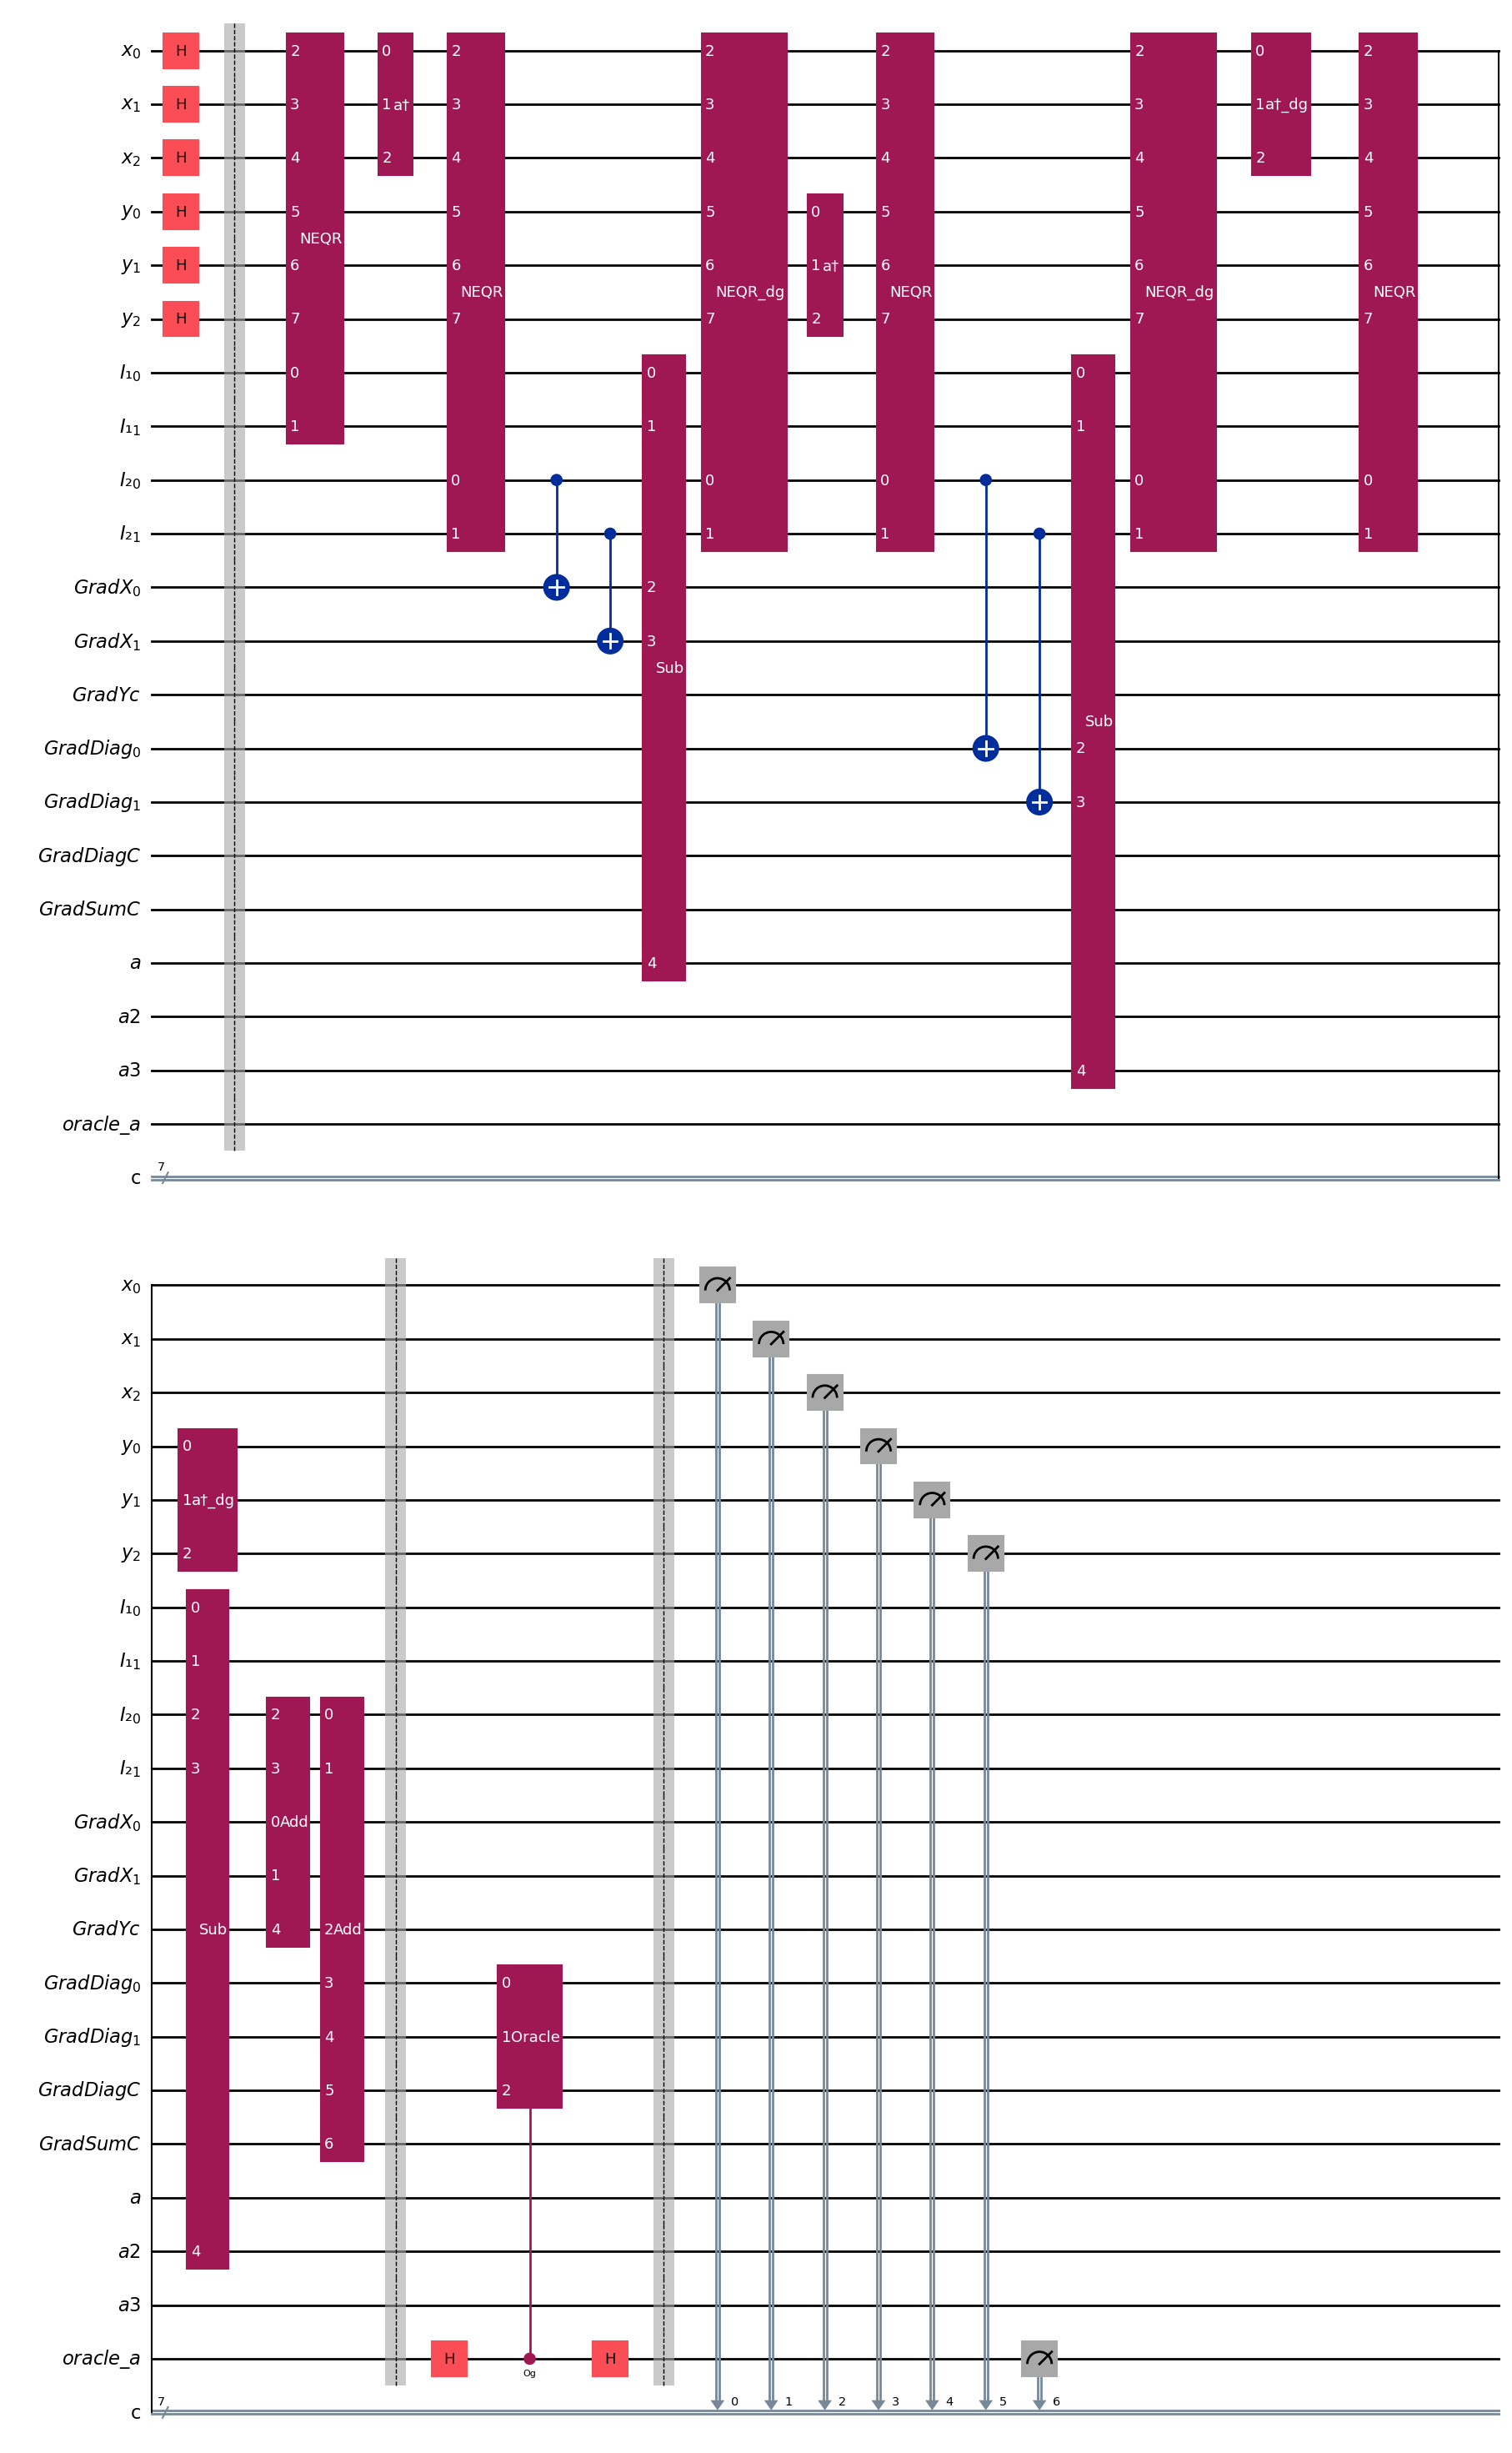

In [170]:
qc.draw('mpl')

In [171]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()


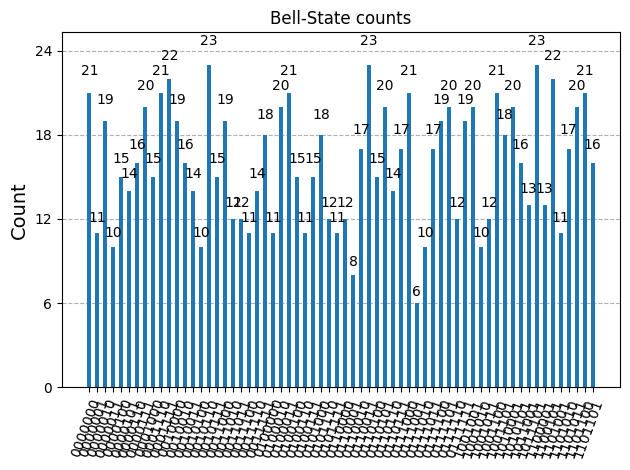

In [172]:
counts = result.get_counts()
plot_histogram(counts, title='Bell-State counts')

In [173]:
print(counts.items())

dict_items([('0010110', 23), ('1101100', 21), ('0101110', 12), ('0000101', 14), ('0110010', 17), ('0111110', 12), ('1001101', 18), ('0100010', 20), ('0110110', 14), ('0000001', 11), ('0010000', 19), ('0001000', 15), ('0100000', 11), ('1010001', 20), ('0010011', 14), ('0000111', 20), ('0110000', 12), ('0000000', 21), ('0110111', 17), ('1011101', 23), ('0100100', 15), ('1001011', 12), ('0111100', 19), ('0000010', 19), ('0110101', 20), ('0100110', 11), ('0111010', 10), ('0001111', 22), ('1101011', 20), ('0010111', 15), ('0010010', 16), ('1100001', 13), ('0111101', 20), ('0100011', 21), ('0111000', 21), ('1001001', 20), ('1101010', 17), ('0010100', 10), ('0011010', 12), ('1100101', 22), ('1001100', 21), ('0001110', 21), ('0111011', 17), ('0000011', 10), ('0110100', 15), ('0011000', 19), ('0011111', 18), ('0110011', 23), ('0000100', 15), ('0011110', 14), ('0011011', 12), ('0100111', 15), ('1001010', 10), ('0101000', 18), ('0011100', 11), ('1010101', 16), ('0101111', 11), ('0000110', 16), ('

In [174]:
dim = 2**num_bits
edge_img = np.zeros((dim, dim), dtype=int)
for qstate, count in counts.items():

    intensity_bin = qstate[:1]
    y_bin = qstate[1:1 + num_bits]
    x_bin = qstate[1 + num_bits:1 + 2*num_bits]

    intensity = int(intensity_bin,2)  
    y = int(y_bin, 2)
    x = int(x_bin, 2)

    edge_img[y, x] = intensity
print(edge_img)

[[0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 0]
 [0 1 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 0]
 [0 1 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


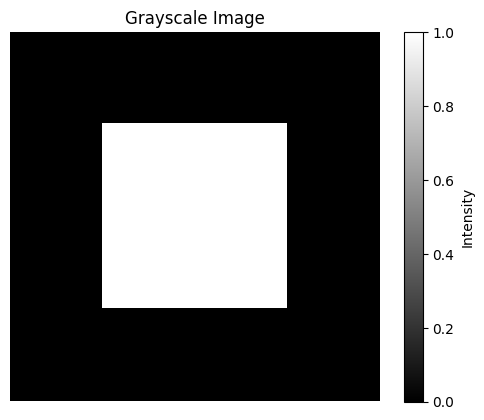

In [175]:
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Grayscale Image')
plt.axis('off')  # Hide axis ticks
plt.show()


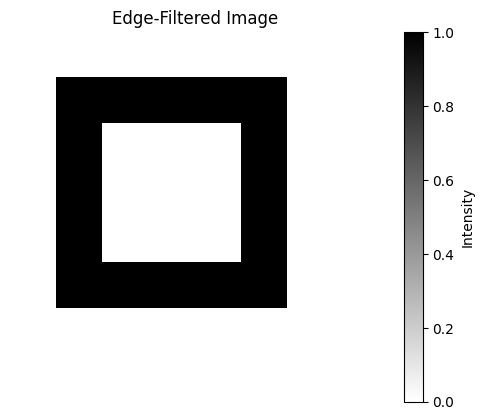

In [176]:
plt.imshow(edge_img, cmap='gray_r', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Edge-Filtered Image')
plt.axis('off')
plt.show()